# Import Packages

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("./Data/Price_Data.csv")
SPY = pd.read_csv("./Data/SPY.csv")

In [3]:
df.head(3)

,Date,Ticker,Close,Return,PM_1W,PM_1M,PM_3M,PM_6M
0,2017-08-28,MMM,202.460007,0.001633,-0.010218,0.012047,0.000099,0.066365
1,2017-08-29,MMM,202.919998,0.002272,-0.012363,0.016022,-0.007581,0.068619
2,2017-08-30,MMM,203.690002,0.003795,0.005033,0.012527,-0.003230,0.075960


In [4]:
# Momentum lag 1 period
df['PM_1W'] = df['PM_1W'].shift(1)
df['PM_1M'] = df['PM_1M'].shift(1)
df['PM_3M'] = df['PM_3M'].shift(1)
df['PM_6M'] = df['PM_6M'].shift(1)

In [5]:
SPY.head(3)

,Date,SPY Close,SPY Return,SPY_1W,SPY_1M,SPY_3M,SPY_6M
0,2017-08-29,244.850006,NaN,0.006875,-0.010639,0.012712,0.019977
1,2017-08-30,246.009994,0.004738,-0.002404,-0.008343,0.014124,0.027616
2,2017-08-31,247.490006,0.006016,0.005929,-0.003080,0.010889,0.031835


# Merge df with SPY

In [6]:
df = pd.merge(df, SPY, on = 'Date', how = 'outer')

In [7]:
df.dropna(inplace=True)
df = df[(df['Date'] >= '2018-03-01') & (df['Date'] <= '2020-03-31')]
df.reset_index(inplace=True, drop=True)

In [8]:
df.head(3)

,Date,Ticker,Close,Return,PM_1W,PM_1M,PM_3M,PM_6M,SPY Close,SPY Return,SPY_1W,SPY_1M,SPY_3M,SPY_6M
0,2018-03-01,MMM,231.339996,-0.017706,0.014342,-0.089394,0.006453,0.160605,267.700012,-0.014541,0.005925,-0.052097,0.043884,0.109455
1,2018-03-01,AOS,62.060001,-0.033183,-0.018201,-0.053803,0.045951,0.181484,267.700012,-0.014541,0.005925,-0.052097,0.043884,0.109455
2,2018-03-01,ABT,58.790001,-0.025526,0.022716,-0.048723,0.074443,0.202991,267.700012,-0.014541,0.005925,-0.052097,0.043884,0.109455


# Train Model

In [9]:
# Date = ['2019-03-01', '2019-06-03', '2019-09-02', '2019-12-02', '2020-03-02']
Date1 = ['2018-03', '2018-06', '2018-09', '2018-12', '2019-03']
Date2 = ['2019-03', '2019-06', '2019-09', '2019-12', '2020-03']

## Define Classes

In [73]:
class Solve():
    def __init__(self, df, Date1, Date2):
        self.df = df 
        self.Date1 = Date1
        self.Date2 = Date2
        
    def Get_Index(self, ticker):
        """
        Get the index of the first trading day of each month in train set and test set 
        """
        Index1 = [] # To store the index of train set
        Index2 = [] # To store the index of test set
        
        self.df_ = self.df.copy()
        self.df_ = self.df_[self.df_['Ticker'] == ticker]
        self.df_.reset_index(inplace=True, drop=True)
        
        for i in range(5):
            Index1.append(self.df_[self.df_['Date'] >= self.Date1[i]].index.values[0])
            Index2.append(self.df_[self.df_['Date'] >= self.Date2[i]].index.values[0])
        
        return Index1, Index2

#     def Get_Index(self, ticker):
#         """
#         Get the index of the first trading day of each month in train set and test set 
#         """
#         Index1 = [] # To store the index of train set
#         Index2 = [] # To store the index of test set
        
#         self.df_ = self.df.copy()
#         self.df_ = self.df_[self.df_['Ticker'] == ticker]
#         self.df_.reset_index(inplace=True, drop=True)
        
#         i1 = self.df_[self.df_['Date'] >= '2018-03'].index.values[0]
#         #i2 = self.df_[self.df_['Date'] >= '2019-03'].index.values[0]
        
#         for i in range(5):
#             if i <= 3:
#                 Index1.append(i1); i1 += 41
#             Index2.append(self.df_[self.df_['Date'] >= self.Date2[i]].index.values[0])
        
#         return Index1, Index2
            
    def Predict_Return(self, ticker):
        """
        Use OLS, Lasso, ElasticNet, KNN to predict next day's return
        """
#         from sklearn.linear_model import LassoCV
        from sklearn.linear_model import LinearRegression
#         from sklearn.linear_model import ElasticNetCV
#         from sklearn.neighbors import KNeighborsRegressor
        
        # Predicted Return 
        y_pred = []
        Index1, Index2 = self.Get_Index(ticker)
        
        for i in range(4):
#             X_train = self.df_.iloc[Index1[i]:Index1[i] + 125, 4:] # Start from 2018-3-1, Freq = Quarter
#             y_train = self.df_.iloc[Index1[i]:Index1[i] + 125, 3]
            X_train = self.df_.iloc[Index1[i]:Index1[i+1], 4:] # Start from 2018-3-1, Freq = Quarter
            y_train = self.df_.iloc[Index1[i]:Index1[i+1], 3]
            
            X_test = self.df_.iloc[Index2[i]:Index2[i+1], 4:] # Start from 2019-3-1, Freq = Quarter
            y_test = self.df_.iloc[Index2[i]:Index2[i+1], 3]
            
#             model = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
            model = LinearRegression().fit(X_train, y_train)
#             model = ElasticNetCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
#             model = KNeighborsRegressor().fit(X_train, y_train)
            y_pred += list(model.predict(X_test).ravel())

        Pred_Cum_Return = 1 
        for i in range(len(y_pred)):
            Pred_Cum_Return *= 1 + y_pred[i]
            
        return y_pred, Pred_Cum_Return
        
    def Select_Stock(self):
        d = '2019-02-28' # Last Trading Day in Train set
        Tickers = list(self.df[self.df['Date'] == d]['Ticker'].values)
        
        max1_return = 1; self.max1_ticker = None # Long 1
        max2_return = 1; self.max2_ticker = None # Long 2
        min1_return = 1; self.min1_ticker = None # Short 1
        min2_return = 1; self.min2_ticker = None # Short 2
        
        for ticker in Tickers:
            r = self.Predict_Return(ticker)
            if r > max1_return:
                max1_return = r; self.max1_ticker = ticker
            elif r > max2_return:
                max2_return = r; self.max2_ticker = ticker
            elif r < min1_return:
                min1_return = r; self.min1_ticker = ticker
            elif r < min2_return:
                min2_return = r; self.min2_ticker = ticker
                
        print("The First Pair: Long " + self.max1_ticker + ", Short " + self.min1_ticker)
        print("The Second Pair: Long " + self.max2_ticker + ", Short " + self.min2_ticker)
        
    def Cal_PnL(self):
        df = self.df.copy()       
        S0 = 25e6 / 2 # Start Wealth For each Pair
        
        # Get Series of each stock's Close Price
        Long1_Close = df[df['Ticker'] == self.max1_ticker]['Close']
        Long2_Close = df[df['Ticker'] == self.max2_ticker]['Close']
        Short1_Close = df[df['Ticker'] == self.min1_ticker]['Close']
        Short2_Close = df[df['Ticker'] == self.min2_ticker]['Close']
        
        # Calculate Shares of each Stock
        Long1_Share = (S0 / Long1_Close.values[0] // 100) * 100 # Cost is the first day's Close
        Long2_Share = (S0 / Long2_Close.values[0] // 100) * 100
        Short1_Share = (S0 / Short1_Close.values[0] // 100) * 100
        Short2_Share = (S0 / Short2_Close.values[0] // 100) * 100
        
        PnL1 = Long1_Share * Long1_Close.diff() - Short1_Share * Short1_Close.diff()
        PnL2 = Long2_Share * Long2_Close.diff() - Short2_Share * Short2_Close.diff()
        
        self.PnL = pd.DataFrame({'PnL1':PnL1, 'PnL2':PnL2})
        self.PnL['PnL1'].iloc[0] = 0
        self.PnL['PnL2'].iloc[0] = 0
        
        self.PnL['Cum Return1'] = self.PnL['PnL1'].cumsum() / 25e6 + 1
        self.PnL['Cum Return2'] = self.PnL['PnL2'].cumsum() / 25e6 + 1
                          
    def Plot_Return(self):
        R1 = self.PnL['Cum Return1'].copy()
        R2 = self.PnL['Cum Return2'].copy()
        
        plt.figure(figsize=(12,6))
        plt.plot(R1, label = 'Pair1')
        plt.plot(R2, label = 'Pair2')
        plt.legend()
        plt.show()

In [74]:
Obj = Solve(df, Date1, Date2)

In [75]:
index1, index2 = Obj.Get_Index('MMM')
print(index1)
print(index2)

[0, 64, 129, 192, 251]
[251, 315, 379, 442, 503]


In [76]:
a, b = Obj.Predict_Return('MMM')

In [77]:
dfxxx = df[df.Ticker == 'MMM'].copy()
dfxxx = dfxxx[(dfxxx.Date >= '2019-03') & (dfxxx.Date < '2020-03')]

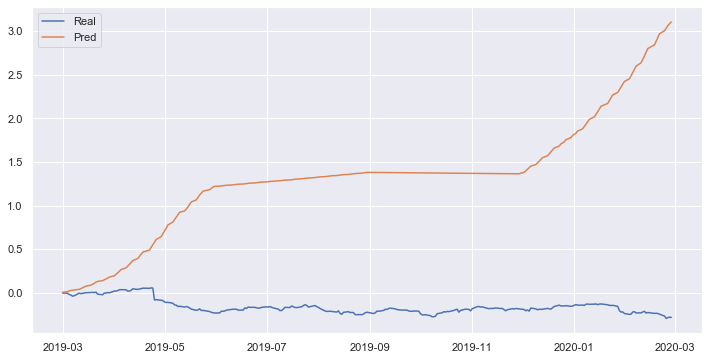

In [78]:
a_ = pd.Series(a) + 1 
a_ = a_.cumprod() - 1

dfxxx = df[df.Ticker == 'MMM'].copy()
dfxxx = dfxxx[(dfxxx.Date >= '2019-03') & (dfxxx.Date < '2020-03')]
r = dfxxx['Return']
 
x = dfxxx['Date'].copy()
x = pd.to_datetime(x)
plt.figure(figsize=(12,6))
plt.plot(x, (r+1).cumprod() - 1)
plt.plot(x, a_)
plt.legend(['Real', 'Pred'])
plt.show()

In [16]:
df[df['Ticker'] == 'MMM']

,Date,Ticker,Close,Return,PM_1W,PM_1M,PM_3M,PM_6M,SPY Close,SPY Return,SPY_1W,SPY_1M,SPY_3M,SPY_6M
0,2018-03-01,MMM,231.339996,-0.017706,0.014342,-0.089394,0.006453,0.160605,267.700012,-0.014541,0.005925,-0.052097,0.043884,0.109455
484,2018-03-02,MMM,230.369995,-0.004193,-0.019746,-0.096363,-0.018207,0.135745,269.079987,0.005155,-0.009985,-0.059646,0.018374,0.088167
968,2018-03-05,MMM,232.809998,0.010592,-0.028057,-0.084162,-0.032099,0.127496,272.190002,0.011558,-0.020494,-0.045003,0.024247,0.087236
1452,2018-03-06,MMM,233.660004,0.003651,-0.046408,-0.070619,-0.042486,0.143692,272.880005,0.002535,-0.020547,-0.034445,0.027093,0.098249
1936,2018-03-07,MMM,235.570007,0.008174,-0.029571,-0.057595,-0.031059,0.162603,272.779999,-0.000366,-0.005648,-0.030897,0.031839,0.108998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248158,2020-03-25,MMM,131.539993,-0.008891,-0.012794,-0.154273,-0.243200,-0.194367,246.789993,0.014970,-0.038173,-0.270871,-0.241886,-0.178186
248629,2020-03-26,MMM,136.179993,0.035274,-0.039994,-0.137725,-0.262957,-0.197927,261.200012,0.058390,0.028292,-0.234570,-0.231710,-0.170788
249100,2020-03-27,MMM,133.240005,-0.021589,-0.009672,-0.072659,-0.229228,-0.168773,253.419998,-0.029786,0.086026,-0.164561,-0.186875,-0.120539
249571,2020-03-30,MMM,137.740005,0.033774,0.066859,-0.105532,-0.245484,-0.190178,261.649994,0.032476,0.107605,-0.186453,-0.215272,-0.142112
